In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from scipy.stats import pearsonr
import statsmodels.api as sm
import optuna
from lightgbm import early_stopping, log_evaluation
from scipy.stats import pointbiserialr
#모델링
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingRegressor
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [430]:
df=pd.read_csv('C:/Users/user-pc/Desktop/수원시 24.3~25.3/df_coffee_권선구.csv')

In [431]:
df = df.drop(columns=['Unnamed: 0'])

# 결측치 처리

In [432]:
df=df.dropna()

In [433]:
df.isna().sum()

ta_ymd        0
cty_rgn_no    0
sex           0
age           0
hour          0
amt           0
cnt           0
day           0
AvgTemp       0
dtype: int64

# 수치형,범주형 변수 분류

In [434]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

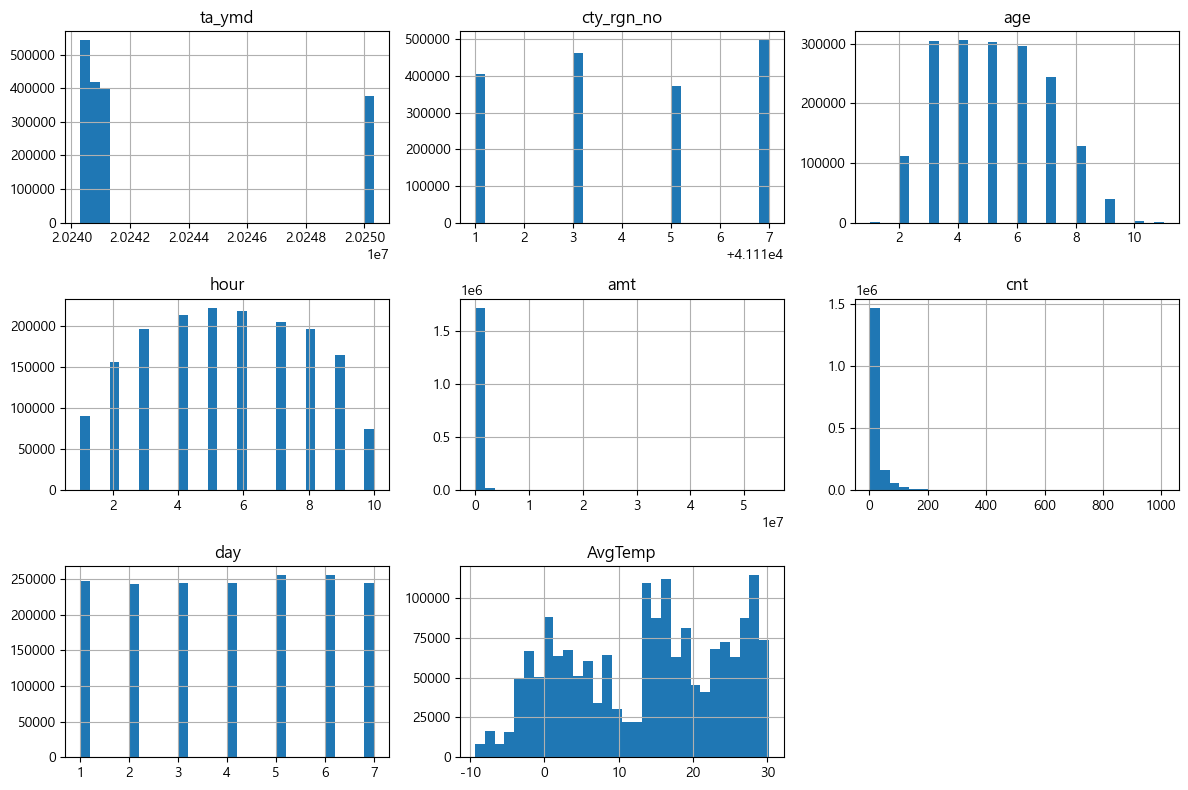

In [435]:
#수치형 변수 히스토그램
df[num_cols].hist(bins=30, figsize=(12,8))
plt.tight_layout()
plt.show()

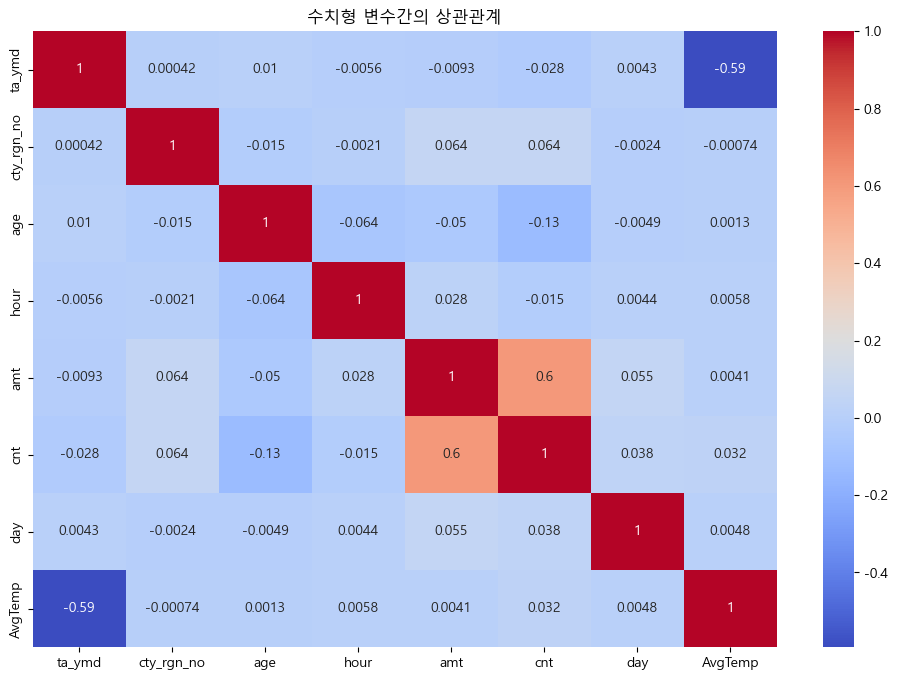

In [436]:
#수치형 변수 상관관계 히트맵
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('수치형 변수간의 상관관계')
plt.show()

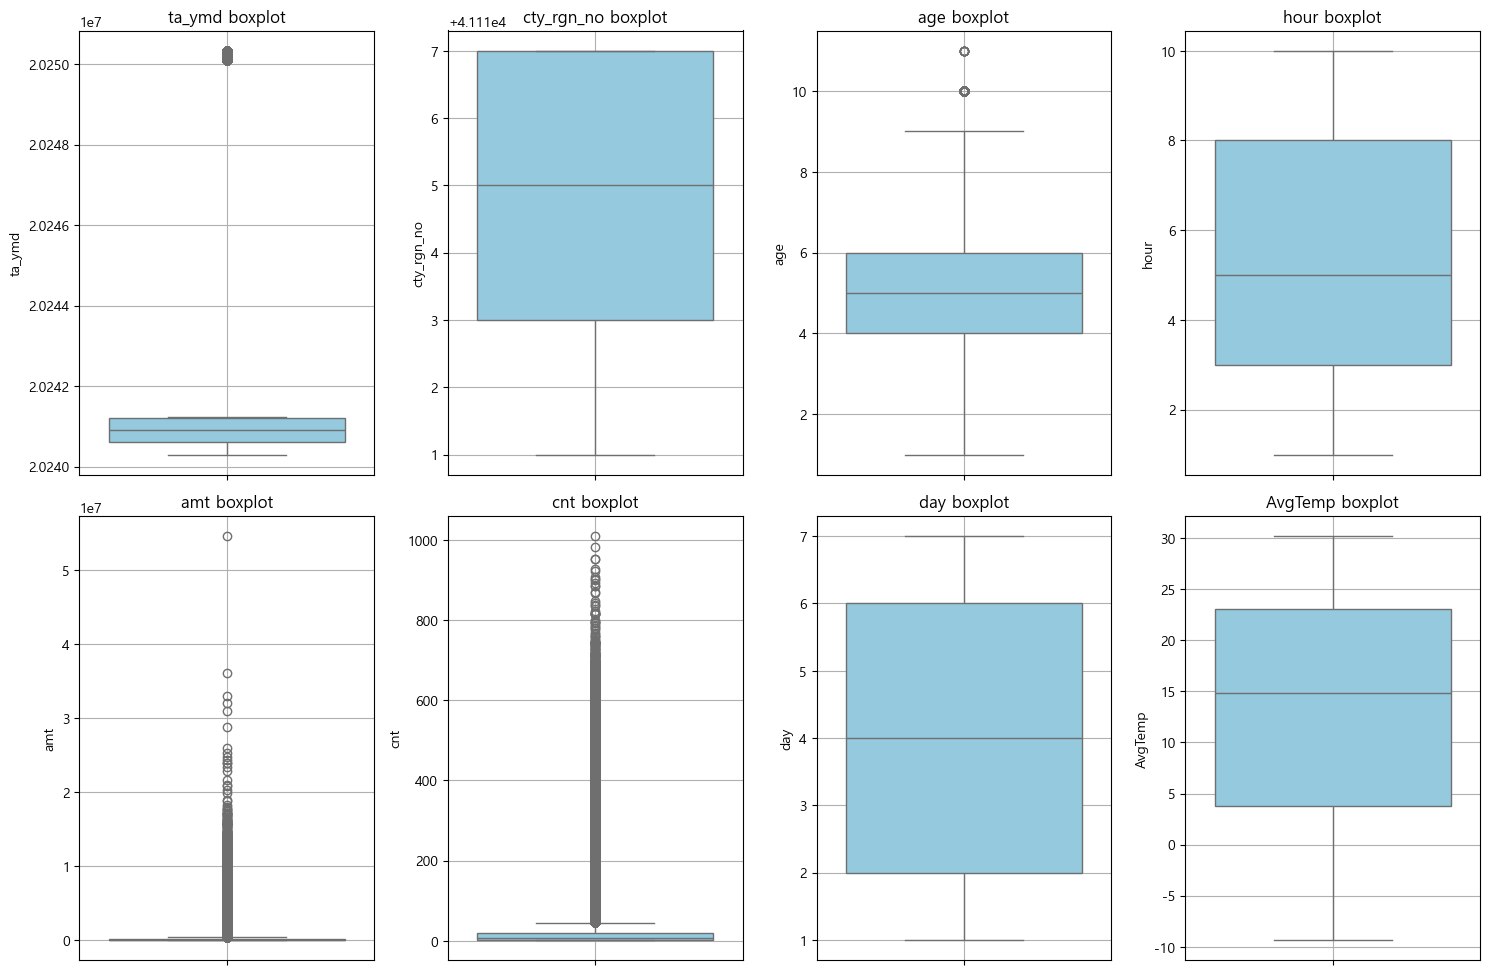

In [437]:
#박스플롯으로 분포와 이상치 확인하기
plt.figure(figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'{col} boxplot')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [438]:
#amt, cnt가 이상치가 많아 로그 변환 후 재시도
df['amt'] = np.log1p(df['amt'])
df['cnt'] = np.log(df['cnt'])

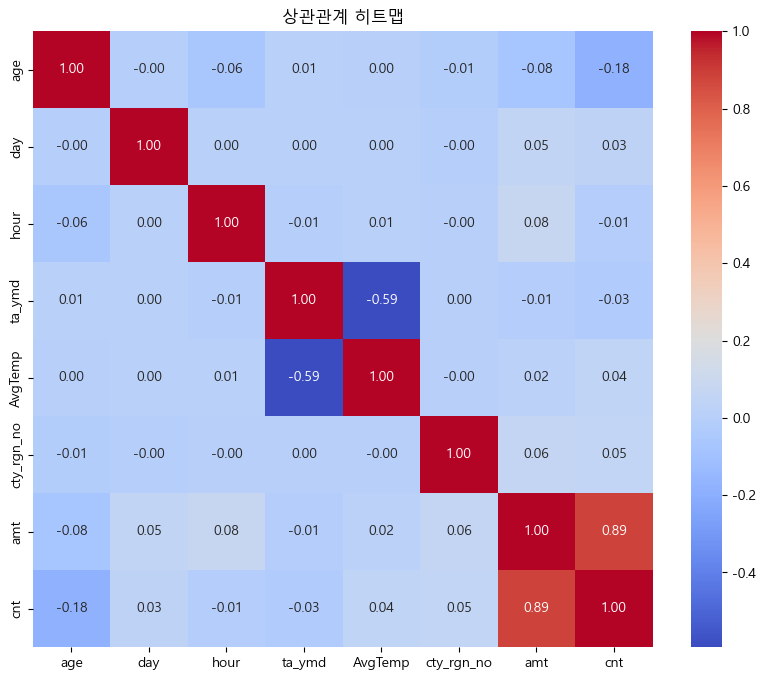

In [439]:
# 상관관계 분석 (로그 변환 후)
features = ['age', 'day', 'hour', 'sex','ta_ymd','AvgTemp','cty_rgn_no']
corr = df[features + ['amt', 'cnt']].corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('상관관계 히트맵')
plt.show()

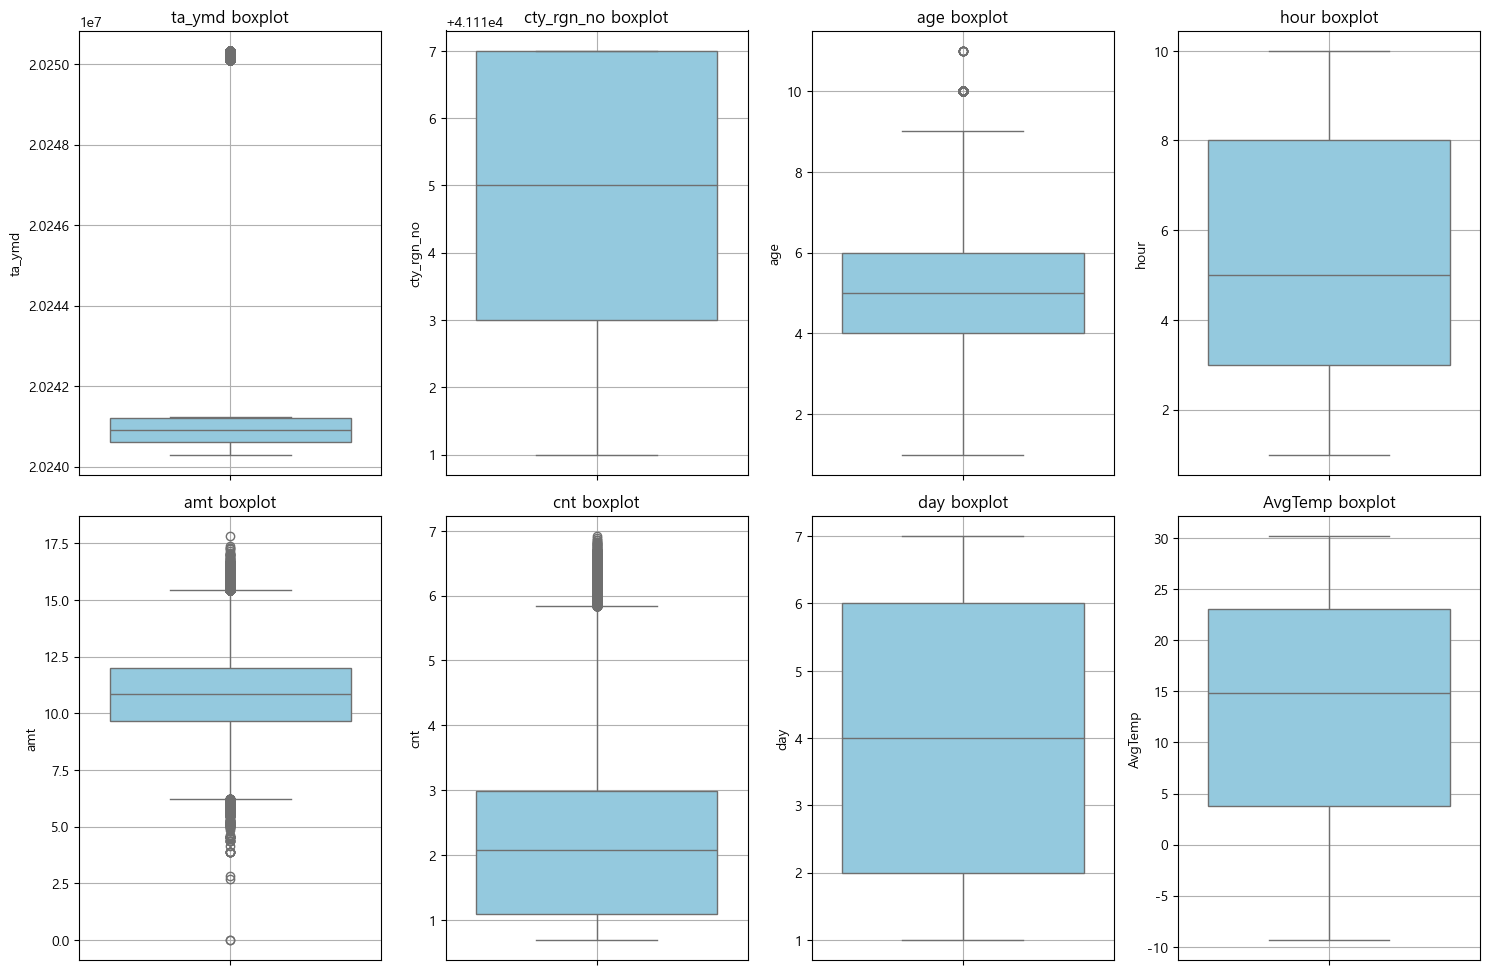

In [440]:
#박스플롯으로 분포와 이상치 다시 확인하기
plt.figure(figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'{col} boxplot')
    plt.grid(True)

plt.tight_layout()
plt.show()
#1. 중앙값 위치 : ta_ymd, amt, cnt, day는 중앙선이 가운데쯤 있으므로 대칭분포 / age, hour는 비대칭 분포
#2. 박스 너비(IQR) : 박스가 넓으면 데이터 분포가 퍼져 있는 것이고, 좁으면 분포가 조밀한 것
#3. 수염 길이 : age 처럼 긴 수염을 가지고 있으면 극단적인 값이 존재하는 것이고 cnt처럼 수염이 비대칭이면 분포가 한쪽으로 치우쳐 있다는 것
#4. 이상치 : 로그변환을 하였음에도 불구하고 amt와 cnt는 여전히 이상치(점의 형태)가 남아있는 모습이다.

# 가설검정
- 1 기온(X:AvgTemp)은 커피 매출(y:amt)에 있어서 상관관계가 있지 않다. (회귀분석)
- 2 성별(X : sex)에 따라 매출(y:amt)에 영향이 있지 않다.(회귀분석)
- 3 커피 매장을 운영하면서 특정 외부 요인(X:모든 변수)에 의해 성별(y:sex)을 예측할 수 없다. (분류분석)
- 4 요일(X:day_of_week)에 따른 평균 커피 매출(y: amt) 은 영향이 없다.(회귀분석)
- 5 연령별 매출금액의 소비 수준(금액을 많이 쓰고 적게 쓰는 정도)패턴을 파악하기. (군집분석)

# 하이퍼 파라미터 튜닝
1. LGBM
2. XGBoost
3. Ridge

In [441]:
#1. LGBM 하이퍼 파리미터 튜닝
# def objective(trial):
#     params = {
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)
#     }

#     model = LGBMRegressor(**params)
#     model.fit(X_train, y_amt_train,
#               eval_set=[(X_test, y_amt_test)],
#               eval_metric='rmse',
#               callbacks=[early_stopping(stopping_rounds=50),log_evaluation(period=0)])
    
#     preds = model.predict(X_test)
#     rmse = mean_squared_error(y_amt_test, preds, squared=False)
#     return rmse

# # === Optuna 최적화 수행 ===
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)

# print("✅ Best Parameters Found by Optuna:")
# print(study.best_params)

#2. XGBoost 하이퍼 파라미터 튜닝
# def objective_xgb(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
#         'random_state': 42
#     }

#     model = XGBRegressor(**params)
#     model.fit(X_amt_train, y_amt_train)
#     y_pred = model.predict(X_amt_test)
#     rmse = mean_squared_error(y_amt_test, y_pred)
#     return rmse

# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=50)

# print("\n✅ Best XGBoost Parameters Found:")
# print(study_xgb.best_params)
# print("Best RMSE:", study_xgb.best_value)

#3. Ridge 하이퍼 파리미터 튜닝
# def objective_ridge(trial):
#     alpha = trial.suggest_float('alpha', 0.0001, 10.0, log=True)
#     model = Ridge(alpha=alpha)
#     model.fit(X_amt_train, y_amt_train)
#     y_pred = model.predict(X_amt_test)
#     rmse = mean_squared_error(y_amt_test, y_pred)
#     return rmse

# study_ridge = optuna.create_study(direction='minimize')
# study_ridge.optimize(objective_ridge, n_trials=50)

# print("\n✅ Best Ridge Parameters Found:")
# print(study_ridge.best_params)

# 하이퍼 파라미터 튜닝 값

In [442]:
best_params_LGBM = {
  'num_leaves': 89,
  'max_depth': 15,
  'learning_rate': 0.0837,
  'n_estimators': 859,
  'min_child_samples': 84,
  'subsample': 0.9619,
  'colsample_bytree': 0.7480,
  'reg_alpha': 3.8135,
  'reg_lambda': 1.5787
}

best_params_XGBoost={
  'n_estimators': 645,
  'max_depth': 14,
  'learning_rate': 0.03498956134885634,
  'subsample': 0.7132225654522615,
  'colsample_bytree': 0.8050397258381967,
  'gamma': 0.3573772428817774,
  'reg_alpha': 3.562730391807268,
  'reg_lambda': 0.511245824338082
}

best_alpha_Ridge = 9.877442360354095

# 하이퍼파리미터 튜닝을 통해 알아낸 하이퍼파리미터 값
- num_leaves=89 : 트리의 리프 수(복잡도)를 뜻하며, 89는 비교적 많고 복잡한 데이터 패턴을 학습한다는 의미이다.(범위 20 ~ 100)
- max_depth=15 : 트리의 최대 깊이를 뜻하며, 15는 깊은 트리이며, 복잡한 의사결정이 가능하다는 의미이다.(범위 3 ~ 15)
- learning_rate=0.0837 : 학습률을 뜻하며, 0.0837은 적절한 학습속도이다.(범위 0.01 ~ 0.3)
- n_estimators=859 : 트리 개수를 뜻하며, 859는 충분히 많은 트리를 쌓았음을 의미한다.(범위 100 ~ 1000+)
- min_child_samples=84 : 리프 노드 최소 샘플 수를 뜻하며, 84는 노이즈를 방지하는 보수적인 제어를 의미한다.(범위 5~100)
- subsample=0.9619 : 데이터 샘플 비율을 뜻하며, 0.9619는 거의 전체 데이터를 학습에 사용함을 의미한다.(범위 0.6 ~ 1.0)
- colsample_bytree=0.7480 : 피처 샘플 비율을 뜻하며, 0.7480은 일부 피처만 사용해 트리를 구성했음을 의미한다.(범위 0.6 ~ 1.0)
- reg_alpha=3.8135 : L1 정규화 강도를 뜻하며, 3.8135는 계수를 0으로 유도하여 변수 선택 효과를 주는 값임을 의미한다.(범위 0 ~ 10)
- reg_lambda=1.5787 : L2 정규화 강도를 뜻하며, 1.5787은 가중치 크기를 억제하여 모델 복잡도를 제어하는 값임을 의미한다. (범위 0 ~ 10) 

In [443]:
df_encoded = pd.get_dummies(df, columns=['sex']).astype(float)

In [444]:
X_amt = df_encoded[['sex_F','sex_M','cnt', 'age','ta_ymd', 'hour', 'day','AvgTemp','cty_rgn_no']]
y_amt = df_encoded['amt']

In [445]:
X_train, X_test, y_amt_train, y_amt_test = train_test_split(X_amt,y_amt,test_size=0.2, random_state=42)
model_amt = LGBMRegressor().fit(X_train, y_amt_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 9
[LightGBM] [Info] Start training from score 10.835839


In [446]:
# RMSE(amt) : 약 0.6681 > 로그 역변환 시 log_e 0.6681 = 약 0.95배 오차, R^2 = 약 0.8315 
# 이 값들로 하여금 이 amt는 83.15% 설명력을 보이는 모델이다. > 모델 성능이 우수함
y_pred_amt = model_amt.predict(X_test)
print("RMSE (amt):",np.sqrt(mean_squared_error(y_amt_test,y_pred_amt)))
print("R^2 (amt):",r2_score(y_amt_test,y_pred_amt))

RMSE (amt): 0.6681296529606043
R^2 (amt): 0.8315403126720473


In [447]:
#피처 변수 추가
# 일단 날짜를 datetime으로 변환
df['ta_ymd'] = pd.to_datetime(df['ta_ymd'])

# 고객 기준 최근 7일 누적 소비 금액
df = df_encoded.sort_values(by=['sex_F','sex_M', 'age', 'ta_ymd'])  # 고객 proxy: sex + age
df['past_7day_amt'] = df.groupby(['sex_F','sex_M', 'age'])['amt'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())

# 고객 기준 최근 30일 누적 구매 횟수
df['past_30day_cnt'] = df.groupby(['sex_F','sex_M', 'age'])['cnt'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# 고객의 평균 방문당 지출 금액
df['mean_amt_per_visit'] = df['amt'] / (df['cnt'] + 1e-5)  # 분모 0 방지

In [487]:
df

,ta_ymd,cty_rgn_no,age,hour,amt,cnt,day,AvgTemp,sex_F,sex_M,sex,past_7day_amt,past_30day_cnt,mean_amt_per_visit
138,20240301.0,41111.0,2.0,5.0,10.089718,1.098612,5.0,-4.523944,0.0,1.0,M,10.089718,1.098612,9.183974
152,20240301.0,41111.0,2.0,6.0,10.590063,1.791759,5.0,-4.523944,0.0,1.0,M,20.679781,2.890372,5.910394
165,20240301.0,41111.0,2.0,7.0,11.262924,1.098612,5.0,-4.523944,0.0,1.0,M,31.942706,3.988984,10.251862
177,20240301.0,41111.0,2.0,8.0,9.617138,1.098612,5.0,-4.523944,0.0,1.0,M,41.559844,5.087596,8.753817
188,20240301.0,41111.0,2.0,9.0,8.231110,0.693147,5.0,-4.523944,0.0,1.0,M,49.790954,5.780744,11.874810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735337,20250331.0,41117.0,10.0,10.0,7.997327,0.693147,1.0,8.224742,1.0,0.0,F,59.228019,25.947679,11.537537
1735367,20250331.0,41117.0,10.0,4.0,10.174430,0.693147,1.0,8.224742,1.0,0.0,F,61.353661,25.947679,14.678388
1736026,20250331.0,41117.0,10.0,6.0,10.621083,0.693147,1.0,8.224742,1.0,0.0,F,63.977417,25.947679,15.322763
1736109,20250331.0,41117.0,10.0,4.0,8.608313,0.693147,1.0,8.224742,1.0,0.0,F,63.869358,25.947679,12.418991


In [448]:
# 피처 선택
features_amt = ['sex_F','sex_M', 'age', 'hour', 'day',
            'past_7day_amt', 'past_30day_cnt', 'mean_amt_per_visit', 'AvgTemp', 'cty_rgn_no']
X = df[features_amt]
y_amt = df['amt']
#모델링(다양한 수치형 변수들을 바탕으로 구매횟수를를 예측하는 분류 모델)
X_amt_train, X_amt_test, y_amt_train, y_amt_test = train_test_split(X, y_amt, test_size=0.2, random_state=42)

In [449]:
model = LGBMRegressor()
model.fit(X_amt_train, y_amt_train)
y_pred_amt = model.predict(X_amt_test)
y_amt_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_amt))
y_amt_r2_score = r2_score(y_amt_test,y_pred_amt)
print("RMSE:", y_amt_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(y_amt_rmse,np.expm1(y_amt_rmse)))
print("R^2 (amt):", y_amt_r2_score)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(y_amt_r2_score * 100))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] Start training from score 10.836061
RMSE: 0.6157564064415718
즉, log_1p 0.6157564064415718 = 약 0.85배의 오차가 있다.
R^2 (amt): 0.856658448457822
또한, 이 모델은 85.67%의 설명력을 가진다.


In [450]:
best_LGBM_model_amt = LGBMRegressor(**best_params_LGBM)
best_LGBM_model_amt.fit(X_amt_train, y_amt_train)
y_pred_best_amt = best_LGBM_model_amt.predict(X_amt_test)
y_amt_best_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_best_amt))
y_amt_best_r2_score = r2_score(y_amt_test,y_pred_best_amt)
print("RMSE:", y_amt_best_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(y_amt_best_rmse,np.expm1(y_amt_best_rmse)))
print("R^2 (amt):", y_amt_best_r2_score)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(y_amt_best_r2_score * 100))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] Start training from score 10.836061
RMSE: 0.5770433969456786
즉, log_1p 0.5770433969456786 = 약 0.78배의 오차가 있다.
R^2 (amt): 0.8741158144083628
또한, 이 모델은 87.41%의 설명력을 가진다.


In [451]:
#XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_amt_train, y_amt_train)
y_pred_xgb_amt = xgb_model.predict(X_amt_test)

xgb_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_xgb_amt))
xgb_r2 = r2_score(y_amt_test, y_pred_xgb_amt)

print("RMSE:", xgb_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(xgb_rmse, np.expm1(xgb_rmse)))
print("R^2 (amt):", xgb_r2)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(xgb_r2 * 100))

RMSE: 0.6130737116103963
즉, log_1p 0.6130737116103963 = 약 0.85배의 오차가 있다.
R^2 (amt): 0.857904733385102
또한, 이 모델은 85.79%의 설명력을 가진다.


In [452]:
best_XGB_model_amt = XGBRegressor(**best_params_XGBoost)
best_XGB_model_amt.fit(X_amt_train, y_amt_train)
y_pred_best_amt = best_XGB_model_amt.predict(X_amt_test)
y_amt_best_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_best_amt))
y_amt_best_r2_score = r2_score(y_amt_test,y_pred_best_amt)
print("RMSE:", y_amt_best_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(y_amt_best_rmse,np.expm1(y_amt_best_rmse)))
print("R^2 (amt):", y_amt_best_r2_score)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(y_amt_best_r2_score * 100))

RMSE: 0.5645107963650584
즉, log_1p 0.5645107963650584 = 약 0.76배의 오차가 있다.
R^2 (amt): 0.8795245027260316
또한, 이 모델은 87.95%의 설명력을 가진다.


In [453]:
#Ridge
ridge_model = Ridge()
ridge_model.fit(X_amt_train, y_amt_train)

# 예측
y_pred_ridge = ridge_model.predict(X_amt_test)

# 평가
ridge_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_ridge))
ridge_r2 = r2_score(y_amt_test, y_pred_ridge)

# 출력
print("RMSE:", ridge_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(ridge_rmse, np.expm1(ridge_rmse)))
print("R^2 (amt):", ridge_r2)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(ridge_r2 * 100))

RMSE: 1.0329425310425109
즉, log_1p 1.0329425310425109 = 약 1.81배의 오차가 있다.
R^2 (amt): 0.5966272625712462
또한, 이 모델은 59.66%의 설명력을 가진다.


In [454]:
best_Ridge_model_amt = Ridge(alpha=best_alpha_Ridge)
best_Ridge_model_amt.fit(X_amt_train, y_amt_train)

# 예측
y_pred_ridge = best_Ridge_model_amt.predict(X_amt_test)

# 평가
best_ridge_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_ridge))
best_ridge_r2 = r2_score(y_amt_test, y_pred_ridge)

# 출력
print("RMSE:", best_ridge_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(best_ridge_rmse, np.expm1(best_ridge_rmse)))
print("R^2 (amt):", best_ridge_r2)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(best_ridge_r2 * 100))

RMSE: 1.0329425302039874
즉, log_1p 1.0329425302039874 = 약 1.81배의 오차가 있다.
R^2 (amt): 0.5966272632261473
또한, 이 모델은 59.66%의 설명력을 가진다.


In [455]:
ensemble = VotingRegressor(estimators=[
    ('LGBM',best_LGBM_model_amt),
    ('XGB',best_XGB_model_amt)
],weights=[0.2,0.8])

ensemble.fit(X_amt_train,y_amt_train)
y_pred_ensemble = ensemble.predict(X_amt_test)

voting_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_ensemble))
voting_r2 = r2_score(y_amt_test, y_pred_ensemble)

print("RMSE:", voting_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(voting_rmse, np.expm1(voting_rmse)))
print("R^2 (amt):", voting_r2)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(voting_r2 * 100))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] Start training from score 10.836061
RMSE: 0.5637217209725199
즉, log_1p 0.5637217209725199 = 약 0.76배의 오차가 있다.
R^2 (amt): 0.8798610695740867
또한, 이 모델은 87.99%의 설명력을 가진다.


# 1. 기온과 커피 매출의 상관관계(회귀)
# H_0(귀무가설) : 기온에 따라 매출 영향을 미치지 않는다.
# H_1(대립가설) : 기온에 따라 매출 영향을 미친다.

In [456]:
corr, p_value = pearsonr(df['AvgTemp'],df['amt'])

print(f"상관계수 : {corr}")
print(f"p값 : {p_value}")
#기온과 매출은 유의미한 관계는 있지만 거의 없는 것처럼 약하다.

상관계수 : 0.017076654633062217
p값 : 3.844266512184432e-112


In [457]:
temp_model = VotingRegressor(estimators=[
    ('LGBM',best_LGBM_model_amt),
    ('XGB',best_XGB_model_amt)
],weights=[0.2,0.8])

temp_model.fit(X_amt_train, y_amt_train)
y_pred_temp_amt = temp_model.predict(X_amt_test)

y_temp_amt_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_temp_amt))
y_temp_amt_r2_score = r2_score(y_amt_test,y_pred_temp_amt)

print("RMSE:", y_temp_amt_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(y_temp_amt_rmse,np.expm1(y_temp_amt_rmse)))
print("R^2 (amt):", y_temp_amt_r2_score)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(y_temp_amt_r2_score * 100))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] Start training from score 10.836061
RMSE: 0.5637217209725199
즉, log_1p 0.5637217209725199 = 약 0.76배의 오차가 있다.
R^2 (amt): 0.8798610695740867
또한, 이 모델은 87.99%의 설명력을 가진다.


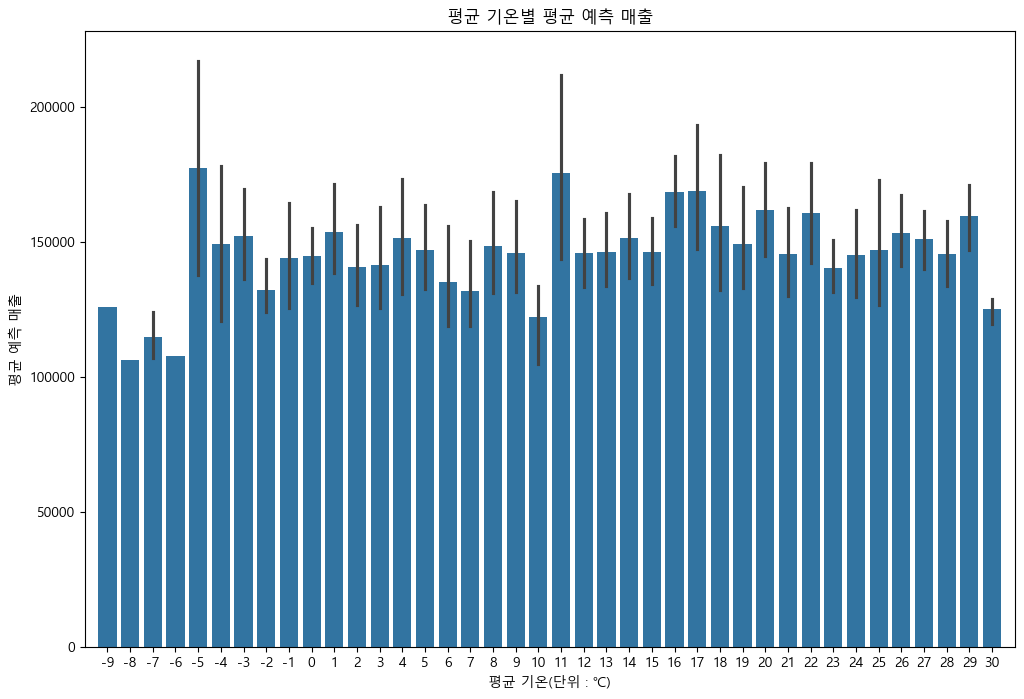

기온이 17.97℃일 때 매출이 246,225원으로 가장 높았다.


In [458]:
X_amt_test_copy = X_amt_test.copy()
X_amt_test_copy['predicted_amt'] = np.expm1(y_pred_temp_amt)

mean_amt_by_AvgTemp = X_amt_test_copy.groupby('AvgTemp')['predicted_amt'].mean()

plt.figure(figsize=(12,8))
sns.barplot(x=mean_amt_by_AvgTemp.index.astype(int), y=mean_amt_by_AvgTemp.values)
plt.title("평균 기온별 평균 예측 매출")
plt.xlim(-1,40)
plt.xlabel("평균 기온(단위 : ℃)")
plt.ylabel("평균 예측 매출")
plt.show()
print("기온이 {:.2f}℃일 때 매출이 {:,.0f}원으로 가장 높았다.".format(mean_amt_by_AvgTemp.sort_values(ascending=False).index[0],mean_amt_by_AvgTemp.sort_values(ascending=False).iloc[0]))

# 2. 성별이 커피 매출에 끼치는 영향(회귀)
# H_0(귀무가설) : 성별에 따라 매출 영향을 미치지 않는다.
# H_1(대립가설) : 성별에 따라 매출 영향을 미친다.
- 대립가설 채택 : 성별이 매출 영향에 큰 기여를 하진 않으나 미약하게나마 성별에 따라 매출 금액의 영향을 미친다.✅

In [459]:
#우선 성별에 따라 가장 영향을 많이 받는 변수 알아보기
#다만 p-value값이 대부분 0.05보다 작으므로 F값은 값이 클수록 집단 간 유의미한 관계가 있다고 볼 수 있으므로 F값이 크면서 p-value값이 작은 값들을 찾아보면
#sex : cnt > amt > age > ta_ymd > AvgTemp > hour > cty_rgn_no 순으로 변수와 유의미한 관계가 있다.
#통계적으로 성별은 cnt의 영향을 제일 많이 받음을 알 수 있으며, 성별에 따라 커피 매출에 어느정도 영향을 받음을 알 수 있다.
df_encoded['sex'] = df_encoded[['sex_F', 'sex_M']].idxmax(axis=1).str.replace('sex_', '')
df = df_encoded.drop(columns=['sex_F', 'sex_M'])

for cat in cat_cols:
    for num in num_cols:
        groups = [df[df[cat]==level][num]for level in df[cat].unique()]

        if len(groups)>1:
            stat, p = f_oneway(*groups)
            print(f"{num} vs {cat} > F-{stat:.2f}, p-value={p:.7f}")
            if p < 0.05:
                print(f"유의수준 0.05보다 작으므로 귀무가설 기각.")
                print(f"성별에 따라 {num}에 대해 영향을 미친다.")
            else:
                print(f"유의수준 0.05보다 크므로 귀무가설 채택")
                print(f"성별에 따라 {num}에 영향을 미치지 않는다.")
        else:
            print("그룹 수 부족")

ta_ymd vs sex > F-28.41, p-value=0.0000001
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 ta_ymd에 대해 영향을 미친다.
cty_rgn_no vs sex > F-2.06, p-value=0.1509635
유의수준 0.05보다 크므로 귀무가설 채택
성별에 따라 cty_rgn_no에 영향을 미치지 않는다.
age vs sex > F-75.97, p-value=0.0000000
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 age에 대해 영향을 미친다.
hour vs sex > F-56.71, p-value=0.0000000
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 hour에 대해 영향을 미친다.
amt vs sex > F-270.31, p-value=0.0000000
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 amt에 대해 영향을 미친다.
cnt vs sex > F-942.87, p-value=0.0000000
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 cnt에 대해 영향을 미친다.
day vs sex > F-8.14, p-value=0.0043372
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 day에 대해 영향을 미친다.
AvgTemp vs sex > F-19.69, p-value=0.0000091
유의수준 0.05보다 작으므로 귀무가설 기각.
성별에 따라 AvgTemp에 대해 영향을 미친다.


In [460]:
corr, p_value = pearsonr(df['hour'],df['amt'])

print(f"상관계수 : {corr}")
print(f"p값 : {p_value}")

#시간대와 매출은 유의미한 관계는 있지만 거의 없는 것처럼 약하다.

상관계수 : 0.0764861339545905
p값 : 0.0


In [461]:
#모델링 시작
# df['sex'] = LabelEncoder().fit_transform(df['sex'])
df_encoded = pd.get_dummies(df, columns=['sex']).astype(float)

In [465]:
#피처 변수 추가
# 일단 날짜를 datetime으로 변환
df['ta_ymd'] = pd.to_datetime(df['ta_ymd'])

# 고객 기준 최근 7일 누적 소비 금액
df = df_encoded.sort_values(by=['sex_F','sex_M', 'age', 'ta_ymd'])  # 고객 proxy: sex + age
df['past_7day_amt'] = df.groupby(['sex_F','sex_M', 'age'])['amt'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())

# 고객 기준 최근 30일 누적 구매 횟수
df['past_30day_cnt'] = df.groupby(['sex_F','sex_M', 'age'])['cnt'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# 고객의 평균 방문당 지출 금액
df['mean_amt_per_visit'] = df['amt'] / (df['cnt'] + 1e-5)  # 분모 0 방지

In [466]:
# 피처 선택
features_amt = ['sex_F','sex_M', 'age', 'hour', 'day',
            'past_7day_amt', 'past_30day_cnt', 'mean_amt_per_visit', 'AvgTemp', 'cty_rgn_no']
X = df[features_amt]
y_amt = df['amt']
#모델링(다양한 수치형 변수들을 바탕으로 구매횟수를를 예측하는 분류 모델)
X_amt_train, X_amt_test, y_amt_train, y_amt_test = train_test_split(X, y_amt, test_size=0.2, random_state=42)

In [470]:
#모델링(다양한 수치형 변수들을 바탕으로 구매횟수를 예측하는 분류 모델)
sex_model = VotingRegressor(estimators=[
    ('LGBM',best_LGBM_model_amt),
    ('XGB',best_XGB_model_amt)
],weights=[0.2,0.8])

sex_model.fit(X_amt_train, y_amt_train)
y_pred_sex_amt = sex_model.predict(X_amt_test)

y_amt_sex_rmse = np.sqrt(mean_squared_error(y_amt_test, y_pred_sex_amt))
y_amt_sex_r2_score = r2_score(y_amt_test,y_pred_sex_amt)

print("RMSE:", y_amt_sex_rmse)
print("즉, log_1p {} = 약 {:.2f}배의 오차가 있다.".format(y_amt_sex_rmse,np.expm1(y_amt_sex_rmse)))
print("R^2 (amt):", y_amt_sex_r2_score)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(y_amt_sex_r2_score * 100))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] Start training from score 10.836061
RMSE: 0.5637217209725199
즉, log_1p 0.5637217209725199 = 약 0.76배의 오차가 있다.
R^2 (amt): 0.8798610695740867
또한, 이 모델은 87.99%의 설명력을 가진다.


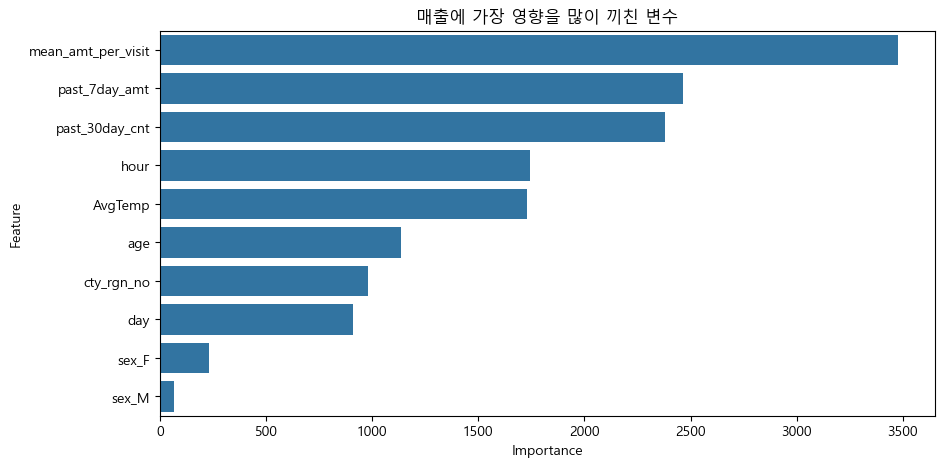

In [471]:
xgb_imp = best_XGB_model_amt.feature_importances_
lgbm_imp = best_LGBM_model_amt.feature_importances_

imp = 0.8 * xgb_imp + 0.2 *  lgbm_imp

features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': imp})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("매출에 가장 영향을 많이 끼친 변수")
plt.show()


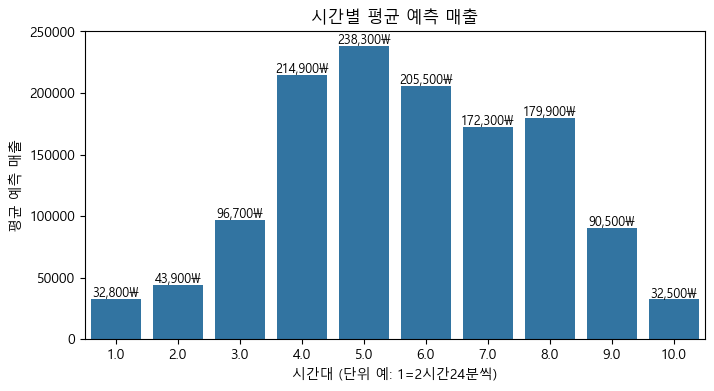

오후 12:00 ~ 14:24에 매출이 238,300원으로 가장 높았다.


In [472]:
#가장 영향을 준 변수인 'hour'(피처변수 제외)로 시간대에 따른 매출 확인
X_amt_test_copy = X_amt_test.copy()
X_amt_test_copy['predicted_amt'] = np.expm1(y_pred_best_amt)

# 시간대별 평균 예측 매출
mean_amt_by_hour = X_amt_test_copy.groupby('hour')['predicted_amt'].mean()

# 시각화
plt.figure(figsize=(8,4))
sns.barplot(x=mean_amt_by_hour.index, y=mean_amt_by_hour.values)
plt.title("시간별 평균 예측 매출")
plt.xlabel("시간대 (단위 예: 1=2시간24분씩)")
plt.ylabel("평균 예측 매출")
for x, y in zip(mean_amt_by_hour.index.astype(int), mean_amt_by_hour.values):
    rounded_y = round(int(y),-2)
    plt.text(x-1, y+1500, f'{rounded_y:,}\\', ha='center', fontsize=9)

plt.show()
print("오후 12:00 ~ 14:24에 매출이 {:,}원으로 가장 높았다.".format(round(int(mean_amt_by_hour.values.max()),-2)))

# 3. 커피 매장을 운영하면서 특정 외부 요인에 의해 성별을 예측(분류)
# H_0(귀무가설) : 특정한 외부 요인에 의해 성별을 예측할 수 없다.
# H_1(대립가설) : 특정한 외부 요인에 의해 성별을 예측할 수 있다.
- 대립가설 채택 : 특정한 외부 요인에 의해 성별을 어느정도 예측할 수 있다.✅

In [ ]:
#가설 검정
def numerical_corr(df, target='sex'):
    print("수치형 변수와 sex 간의 Pearson 상관계수:")
    num_cols = df.select_dtypes(include=np.number).columns.drop(target)
    for col in num_cols:
        corr, p = pearsonr(df[col], df[target])
        print(f"{col:20s} | 상관계수: {corr:.4f}, p-value: {p:.4e}")

numerical_corr(df, target='sex')

print("이로써 p-value값은 모두 0.05보다 낮아 sex와 유의미한 관계를 가지고 있음을 알 수 있다.")

수치형 변수와 amt 간의 Pearson 상관계수:
ta_ymd               | 상관계수: -0.0040, p-value: 9.8045e-08
cty_rgn_no           | 상관계수: 0.0011, p-value: 1.5096e-01
age                  | 상관계수: -0.0066, p-value: 2.8758e-18
hour                 | 상관계수: 0.0057, p-value: 5.0403e-14
amt                  | 상관계수: 0.0125, p-value: 9.8319e-61
cnt                  | 상관계수: -0.0233, p-value: 5.3442e-207
day                  | 상관계수: -0.0022, p-value: 4.3372e-03
AvgTemp              | 상관계수: 0.0034, p-value: 9.1303e-06
이로써 p-value값은 모두 0.05보다 낮아 amt와 유의미한 관계를 가지고 있음을 알 수 있다.


In [483]:
#피처 변수 추가
# 일단 날짜를 datetime으로 변환
df['ta_ymd'] = pd.to_datetime(df['ta_ymd'])

# 고객 기준 최근 7일 누적 소비 금액
df = df_encoded.sort_values(by=['sex_F','sex_M', 'age', 'ta_ymd'])  # 고객 proxy: sex + age
df['past_7day_amt'] = df.groupby(['sex_F','sex_M', 'age'])['amt'].transform(lambda x: x.rolling(window=7, min_periods=1).sum())

# 고객 기준 최근 30일 누적 구매 횟수
df['past_30day_cnt'] = df.groupby(['sex_F','sex_M', 'age'])['cnt'].transform(lambda x: x.rolling(window=30, min_periods=1).sum())

# 고객의 평균 방문당 지출 금액
df['mean_amt_per_visit'] = df['amt'] / (df['cnt'] + 1e-5)  # 분모 0 방지

In [484]:
#모델링(다양한 수치형 변수들을 바탕으로 성별을 예측하는 분류 모델)
features_amt =['amt','cnt', 'age', 'AvgTemp', 'hour', 'day', 'cty_rgn_no','mean_amt_per_visit','past_7day_amt','past_30day_cnt']

X = df[features_amt]
y_sex_F = LabelEncoder().fit_transform(df['sex_F'])
y_sex_M = LabelEncoder().fit_transform(df['sex_M'])

X_train, X_test, y_sex_train, y_sex_test = train_test_split(X, y_sex_F, test_size=0.2, random_state=42)
model = LGBMClassifier()
model.fit(X_train, y_sex_train)
y_pred_sex = model.predict(X_test)

# 정확도
accuracy = accuracy_score(y_sex_test, y_pred_sex)
print("정확도 (Accuracy):", accuracy)

# 상세 리포트 (정밀도, 재현율 등)
print("\n분류 리포트 (Classification Report):")
print(classification_report(y_sex_test, y_pred_sex))

# 혼동 행렬
print("혼동 행렬 (Confusion Matrix):")
print(confusion_matrix(y_sex_test, y_pred_sex))

#결과
print("정확도는 약 62.1%이며 이는 전체 예측 중 62.1%만 정답을 맞췄다는 의미, 모델이 어느정도는 성별을 예측")
print("정밀도, 재현율, f1-score 모두 0.60 수준이며 여성을 더 잘 예측함을 알 수 있다.")
print("혼동행렬을 통해 남성 예측 정확도 약 59.5% / 여성 예측 정확도 64.6%로 알 수 있다.")

[LightGBM] [Info] Number of positive: 670233, number of negative: 718817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482512 -> initscore=-0.069981
[LightGBM] [Info] Start training from score -0.069981
정확도 (Accuracy): 0.6205786392446071

분류 리포트 (Classification Report):
              precision    recall  f1-score   support

           0       0.63      0.65      0.64    179923
           1       0.61      0.59      0.60    167340

    accuracy                           0.62    347263
   macro avg       0.62      0.62      0.62    347263
weighted avg       0.62      0.62      0.62    347263

혼동 행렬 (Confusion Matrix):
[[116335  63588]


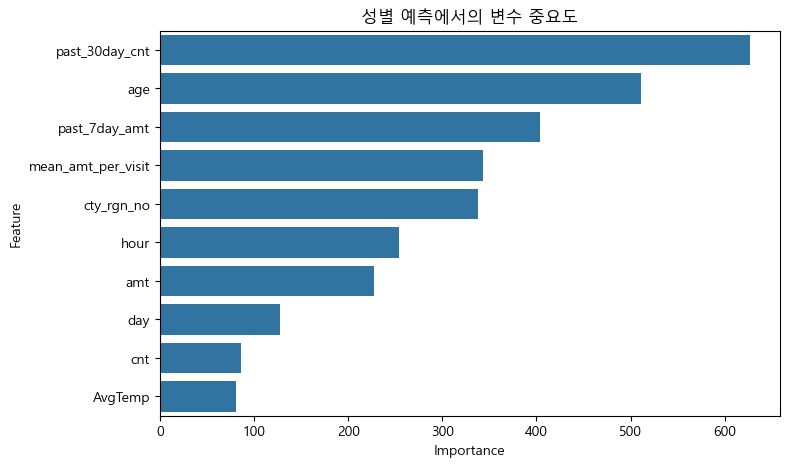

In [ ]:
#성별을 예측하는데 가장 크게 작용한 변수 알아보기
importances = model.feature_importances_
feature_names = X.columns

# 시각화
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("성별 예측에서의 변수 중요도")
plt.show()

In [485]:
features_amt = ['amt','cnt', 'age', 'AvgTemp', 'hour', 'day', 
                'cty_rgn_no','mean_amt_per_visit','past_7day_amt','past_30day_cnt']

# 피처, 타겟 정의 및 모델 훈련
X = df[features_amt]
y = LabelEncoder().fit_transform(df['sex_F'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sex_model = LGBMClassifier()
sex_model.fit(X_train, y_train)

# 사용자 입력 받기 및 예측 함수
def predict_sex_by_input():
    print("아래 수치형 변수들을 입력해주세요.")
    input_data = []

    for feature in features_amt:
        while True:
            try:
                value = float(input(f"{feature} 값 입력: "))
                input_data.append(value)
                break
            except ValueError:
                print("유효한 숫자를 입력해주세요.")

    input_array = np.array(input_data).reshape(1, -1)
    pred = sex_model.predict(input_array)[0]
    prob = sex_model.predict_proba(input_array)[0][1]  # 여성일 확률

    result = "여자" if pred == 1 else "남자"
    print(f"예측 성별: {result}")
    print(f"여자일 확률: {prob:.2%}")
    print(f"남자일 확률: {(1 - prob):.2%}")

# 실행
predict_sex_by_input()

[LightGBM] [Info] Number of positive: 670233, number of negative: 718817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1556
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482512 -> initscore=-0.069981
[LightGBM] [Info] Start training from score -0.069981
아래 수치형 변수들을 입력해주세요.
예측 성별: 여자
여자일 확률: 71.88%
남자일 확률: 28.12%


# 4. 요일에 따른 평균 커피 매출 영향(회귀)
# H_0(귀무가설) : 특정 요일이 커피 매출을 예측할 수 없다.
# H_1(대립가설) : 특정 요일이 커피 매출을 예측할 수 있다.
- 대립가설 채택 : 특정 요일로 커피 매출을 예측할 수 있다.(토요일)✅ 

In [ ]:
corr, p_value = pearsonr(df['amt'],df['day'])

print(f"상관계수 : {corr}")
print(f"p-value : {p_value}")
#요일과 매출은 유의미한 관계는 있지만 거의 없는 것처럼 약하다.

상관계수 : 0.05177180419442588
p-value : 0.0


In [486]:
# 피처 선택
features_amt = ['sex_F','sex_M', 'age', 'hour', 'day',
            'past_7day_amt', 'past_30day_cnt', 'mean_amt_per_visit', 'AvgTemp', 'cty_rgn_no']
X = df[features_amt]
y_day = df['amt']
#모델링(다양한 수치형 변수들을 바탕으로 구매횟수를를 예측하는 분류 모델)
X_train, X_test, y_day_train, y_day_test = train_test_split(X, y_day, test_size=0.2, random_state=42)
day_model = VotingRegressor(estimators=[
    ('LGBM',best_LGBM_model_amt),
    ('XGB',best_XGB_model_amt)
],weights=[0.2,0.8])
day_model.fit(X_train, y_day_train)
y_pred_day_amt = day_model.predict(X_test)
y_day_amt_rmse = np.sqrt(mean_squared_error(y_day_test, y_pred_day_amt))
y_day_amt_r2_score = r2_score(y_day_test,y_pred_day_amt)
print("RMSE:", y_day_amt_rmse)
print("즉, 약 {:.2f}배의 오차가 있다.".format(y_day_amt_rmse))
print("R^2 (amt):", y_day_amt_r2_score)
print("또한, 이 모델은 {:.2f}%의 설명력을 가진다.".format(y_day_amt_r2_score * 100))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 1389050, number of used features: 10
[LightGBM] [Info] Start training from score 10.836061
RMSE: 0.5637217209725199
즉, 약 0.56배의 오차가 있다.
R^2 (amt): 0.8798610695740867
또한, 이 모델은 87.99%의 설명력을 가진다.


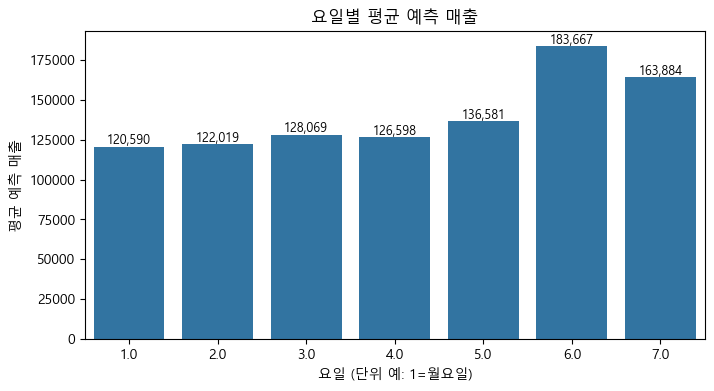

토요일에 매출이 183667원으로 가장 높다


In [ ]:
X_amt_test_copy = X_amt_test.copy()
X_amt_test_copy['predicted_amt'] = np.expm1(y_pred_amt)

# 요일별 평균 예측 매출
mean_amt_by_day = X_amt_test_copy.groupby('day')['predicted_amt'].mean().astype(int)

# 시각화
plt.figure(figsize=(8,4))
sns.barplot(x=mean_amt_by_day.index, y=mean_amt_by_day.values)
plt.title("요일별 평균 예측 매출")
plt.xlabel("요일 (단위 예: 1=월요일)")
plt.ylabel("평균 예측 매출")

for x, y in zip(mean_amt_by_day.index.astype(int), mean_amt_by_day.values):
    plt.text(x-1, y+1500, f'{y:,.0f}', ha='center', fontsize=9)
plt.show()
print("토요일에 매출이 {}원으로 가장 높다".format(mean_amt_by_day.max()))

# 5. 연령별 매출금액의 소비 수준 패턴 파악하기(군집)

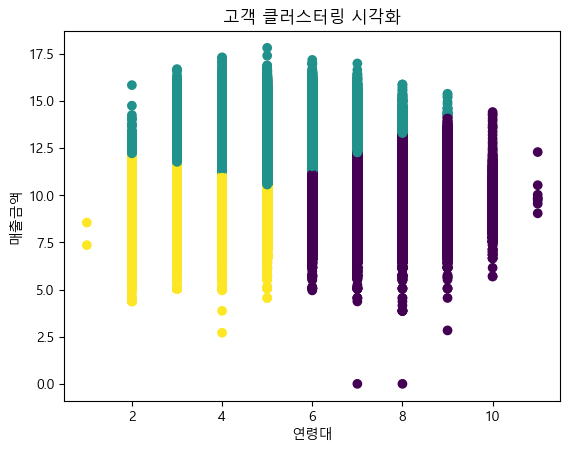

 청록색 : 지속적으로 높은 지출을 하는 고객층이며 전 연령대에 걸쳐 있음을 볼 수 있다.
 보라색 : 낮은 지출을 하는 고객층이며 이 고객들은 대부분 60대 이상(고령층)이 이에 해당한다.
 노란색 : 매출금액이 평균적으로 보통 혹은 낮은 수준의 지출을 하는 젊은 연령대의 고객층이다.


In [ ]:
#연령대와 매출금액 간에 패턴 시각화하기
X = df[['age', 'amt']]

# KMeans 모델 적용
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 클러스터 시각화
plt.scatter(X['age'], X['amt'], c=df['cluster'], cmap='viridis')
plt.xlabel('연령대')
plt.ylabel('매출금액')
plt.title('고객 클러스터링 시각화')
plt.show()
print(" 청록색 : 지속적으로 높은 지출을 하는 고객층이며 전 연령대에 걸쳐 있음을 볼 수 있다." \
"\n 보라색 : 낮은 지출을 하는 고객층이며 이 고객들은 대부분 60대 이상(고령층)이 이에 해당한다." \
"\n 노란색 : 매출금액이 평균적으로 보통 혹은 낮은 수준의 지출을 하는 젊은 연령대의 고객층이다.")